<a href="https://colab.research.google.com/github/min207/2023-1-ESAA/blob/main/ESAA230602.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **04. 위성 이미지 분류**

----
### **4-1. 텐서플로 데이터셋 로드**
- EuroSAT 데이터셋: 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값을 정리한 데이터셋
  + 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공
  + tensorflow_datasets 라이브러리를 불러와서 사용 

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

- (훈련 셋, 검증 셋), 메타 정보 순으로 정리되어 반환
- info 변수에 저장되는 메타 정보는 with_info = True 옵션일 때만 불러올 수 있음
  + False면 메타 정보 없이 (훈련 셋, 검증 셋) 형태의 투플로 반환 

- URL을 통해 데이터 다운로드
- 80%는 훈련 셋, 20%는 검증 셋으로 분할 후 저장 
- 이미지는 (64, 64, 3) 형태 

In [2]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = "/content/dataset"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True, as_supervised=True, with_info=True, data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/dataset/eurosat/rgb/2.0.0.incomplete6DN50J/eurosat-train.tfrecord*...:   0%|          | 0/2…

Dataset eurosat downloaded and prepared to /content/dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


- info 변수를 출력하면, 데이터셋에 대한 기본 정보 제공
- EuroSAT 데이터셋의 2가지 유형 중에서 JPEG 이미지로 인코딩한 RGB 데이터셋을 다운로드한 상태 

In [3]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path=PosixGPath('/tmp/tmpyce7v6tgtfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('im

- 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력
- show_examples 함수 사용 

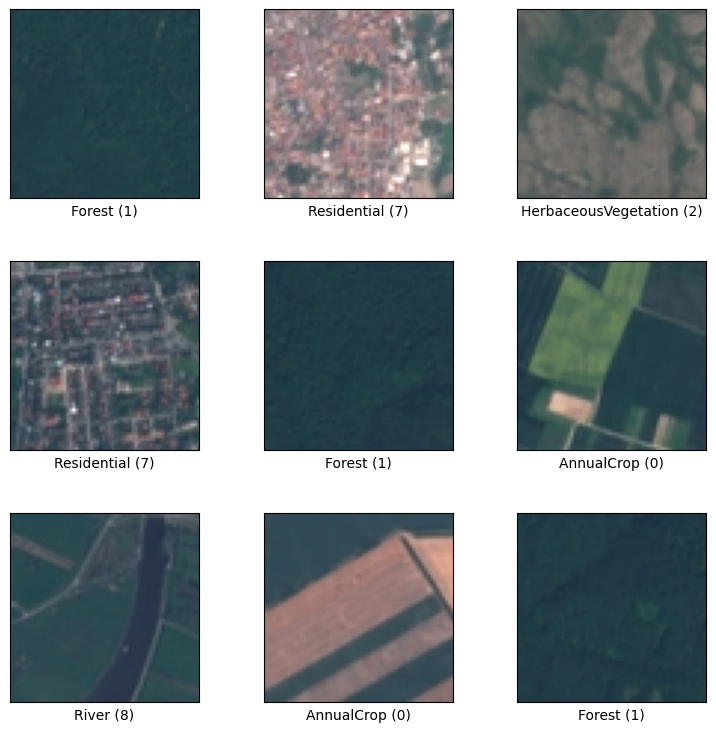

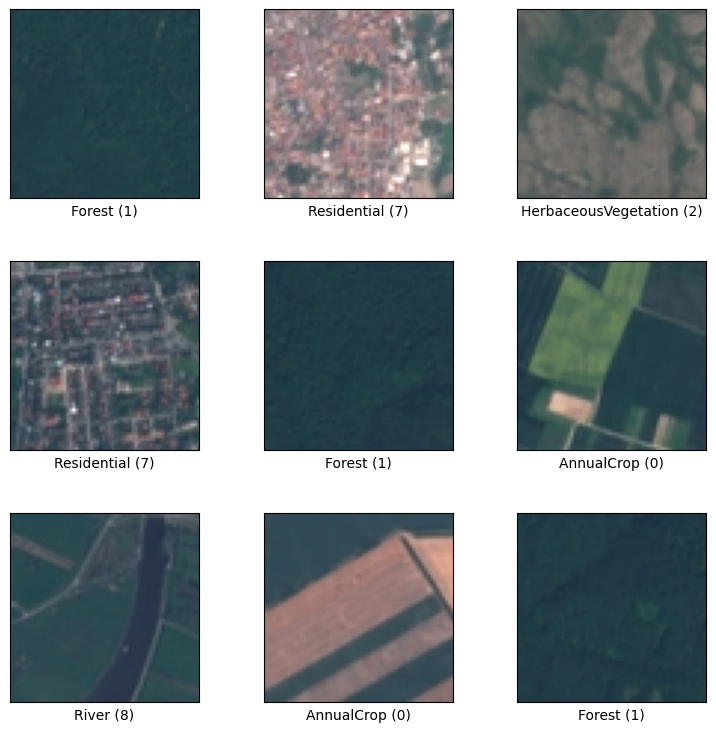

In [4]:
# 데이터 확인
tfds.show_examples(train_ds, info)

- as_dataframe 함수를 사용하여 샘플 이미지 10개를 화면에 표시 

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
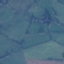
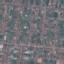
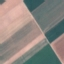
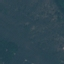
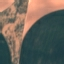
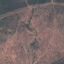
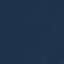
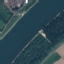
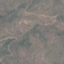
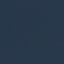

In [5]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

- 토지이용분류에 해당하는 정답 클래스 개수는 10개
  + 0은 경작지, 9는 바다/호수 

In [6]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


- 클래스를 나타내는 숫자 레이블을 메타 데이터의 문자열로 변환 가능
- 메타 데이터의 features 값 중에서 label에 해당하는 메타 정보에 int2str() 메소드 적용
- 6은 영구작물 

In [7]:
# 숫자 레이블을 활용하여 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


### **4-2. 데이터 전처리**
- 텐서플로 데이터셋을 사용하면 딥러닝 학습에 필요한 데이터셋을 쉽게 구할수 있고, 데이터 전처리 과정이 매우 쉽다는 장점이 있음 
- 텐서플로 연산은 float32 숫자 값을 사용하기 때문에 cast 함수를 사용해 자료형을 float32로 변환
- map함수는 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에서 유용
- num_parallel_calls 옵션을 오토튠으로 지정해 텐서플로 병렬연산 처리를 자동으로 최적화

- 오토튠을 적용하지 않으면 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래 걸림
  + 오토튠을 적용하면 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 더 짧은 시간에 처리 

- 정규화 변환을 마친 데이터셋에 shuffle() 메소드를 적용하면 순서를 랜덤하게 섞음
  + 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성을 부여하는 개념 

- prefetch() 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템 조율
  + 병렬 처리를 통해 모델 훈련 시간 단축 

In [8]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

### **4-3. 모델 훈련 및 검증**
- 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성 

In [9]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([
      
      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

model = build_model()

- 예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표를 설정하고, 모델을 50 epoch 훈련 

In [10]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 286s 828ms/step - loss: 1.5735 - accuracy: 0.4477 - val_loss: 1.9347 - val_accuracy: 0.2922
Epoch 2/50
338/338 [==============================] - 265s 785ms/step - loss: 1.2073 - accuracy: 0.5747 - val_loss: 0.9365 - val_accuracy: 0.6687
Epoch 3/50
338/338 [==============================] - 225s 664ms/step - loss: 1.0173 - accuracy: 0.6380 - val_loss: 0.7381 - val_accuracy: 0.7437
Epoch 4/50
338/338 [==============================] - 217s 642ms/step - loss: 0.9270 - accuracy: 0.6721 - val_loss: 0.8518 - val_accuracy: 0.6946
Epoch 5/50
338/338 [==============================] - 204s 604ms/step - loss: 0.8420 - accuracy: 0.7014 - val_loss: 0.6019 - val_accuracy: 0.7993
Epoch 6/50
338/338 [==============================] - 216s 640ms/step - loss: 0.7528 - accuracy: 0.7387 - val_loss: 0.5433 - val_accuracy: 0.8272
Epoch 7/50
338/338 [==============================] - 210s 622ms/step - loss: 0.6959 - accuracy: 0.7577 - val_loss: 0.5092 -

- 모델은 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소하지만 그 이후는 과대적합 경향을 나타냄 

In [11]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

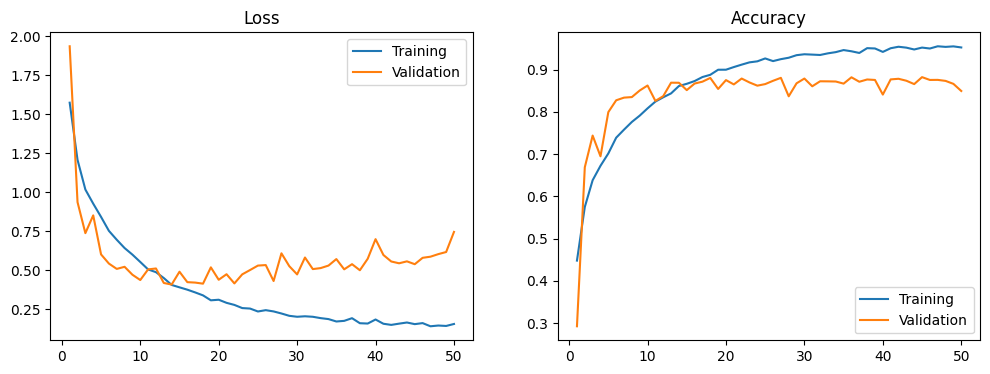

In [12]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

### **4-4. 데이터 증강**
- 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법으로 데이터 증강 기법 사용
- 데이터 증강: 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식으로, 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념

- 먼저 EuroSAT 데이터셋 중에서 하나의 샘플 이미지를 선택하여 시각화 

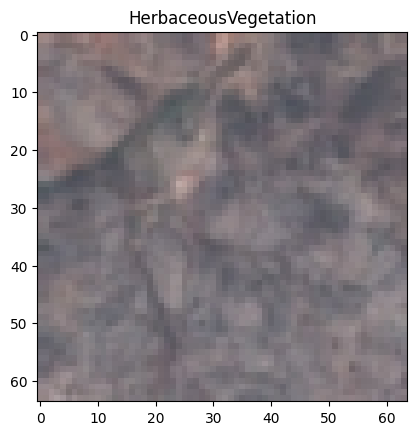

In [13]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [14]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

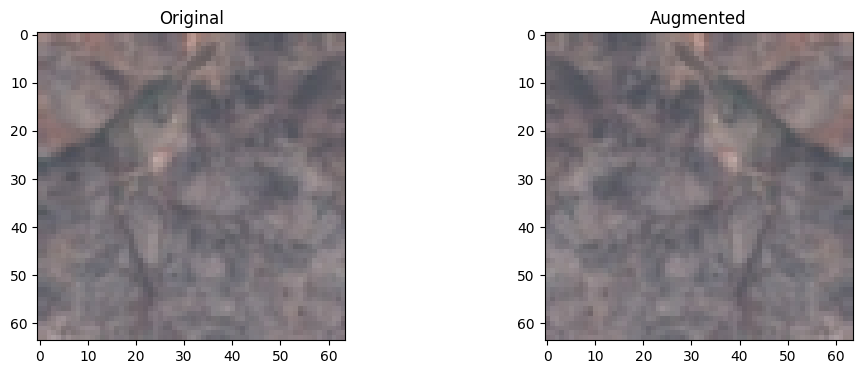

In [15]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

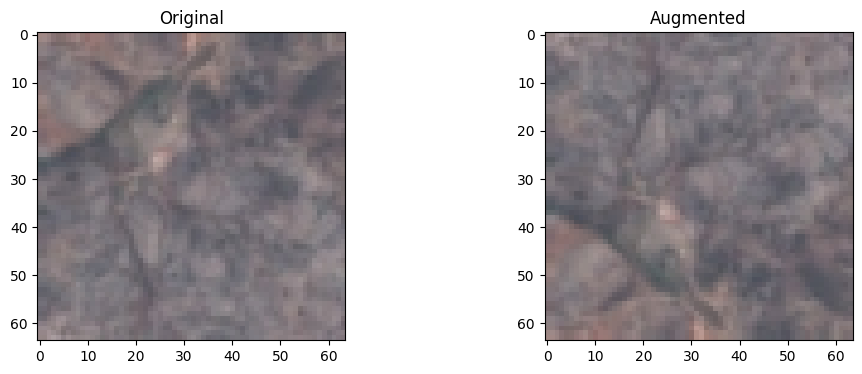

In [16]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

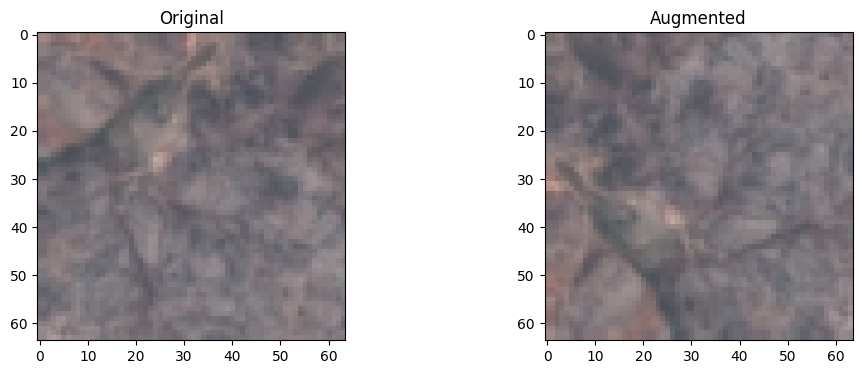

In [17]:
# 반시계 방향 90도 회전 
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

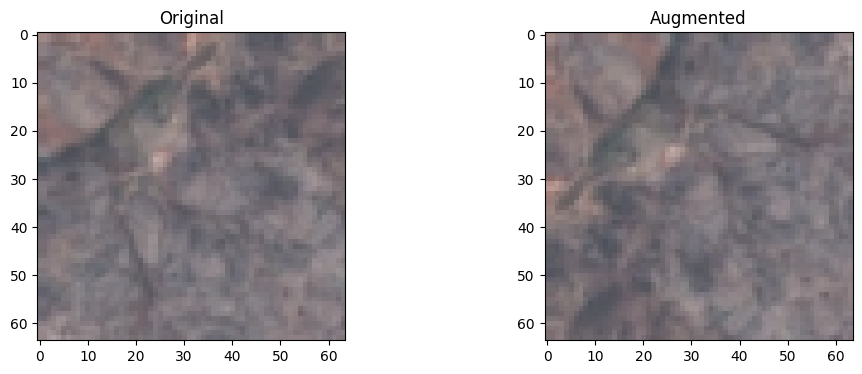

In [18]:
# 이미지 텐서 행렬의 도치 
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

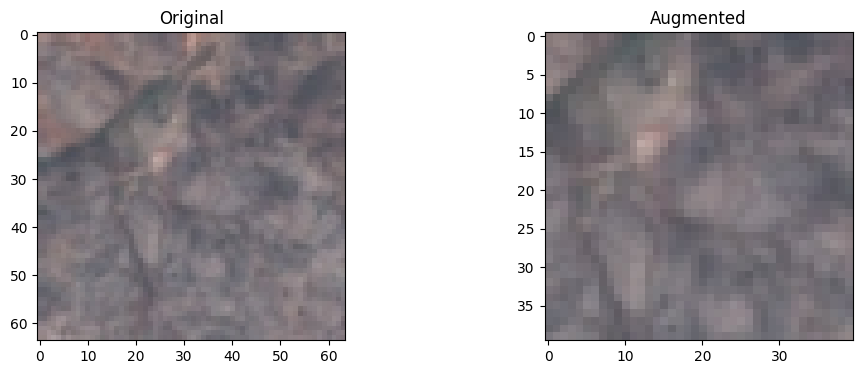

In [19]:
# 이미지의 중심에서 일정 부분 자르기 
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

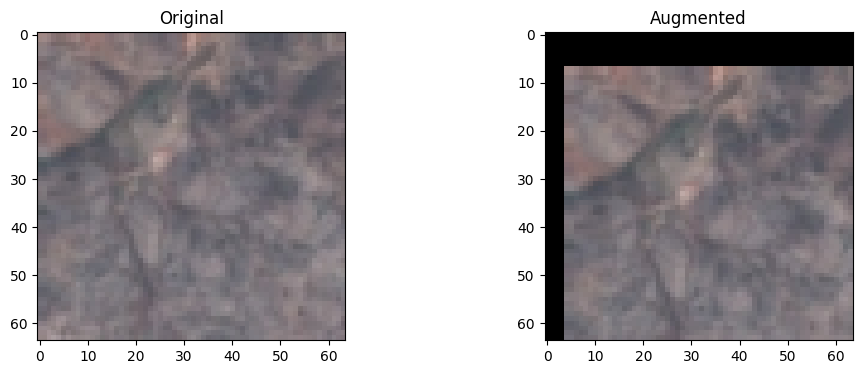

In [20]:
# 원본 이미지가 상화좌우 랜덤한 방향으로 시프트 이동
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

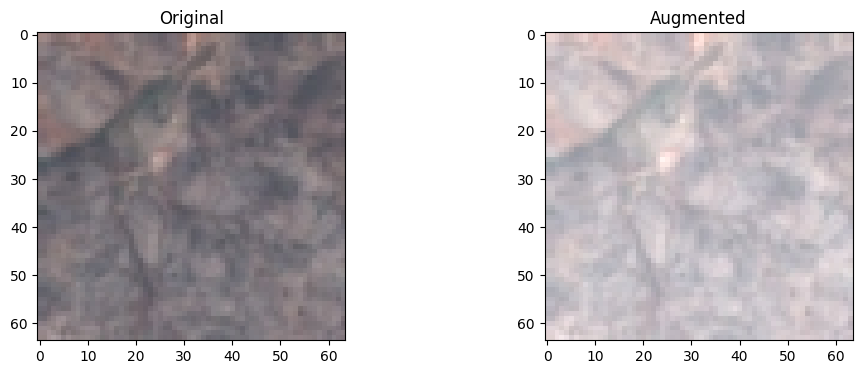

In [21]:
# 이미지 밝기 직접 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

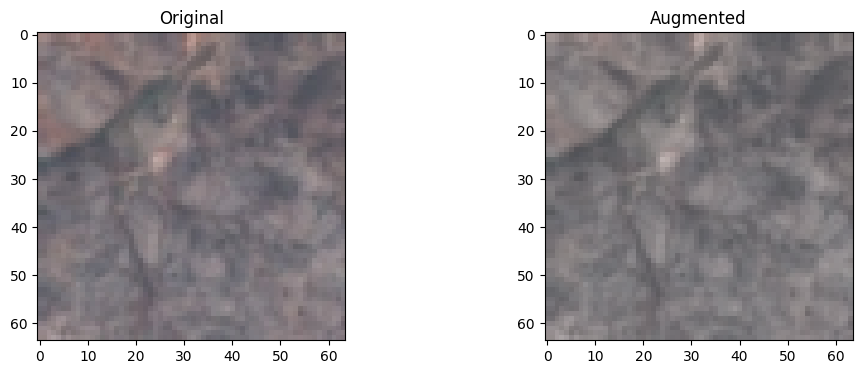

In [22]:
# 이미지 채도 변경 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

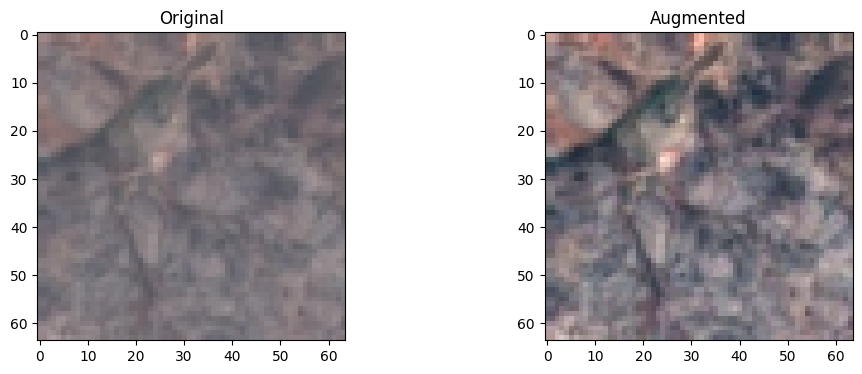

In [23]:
# 이미지 대비 조정 
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

- data_augmentation 사용자 함수를 정의
  + 랜덤성을 부여하기 위해 random_으로 시작하는 함수 적용
  + map 함수로 원본 데이터셋 적용, shuffle 함수와 batch 함수 등을 적용해 미니 배치로 만들어줌 

In [24]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE) 
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


- 모델 인스턴스를 생성, 컴파일을 거쳐 50 epoch 훈련
- 데이터 증강 전후로 성능 자체는 큰 차이가 없음 

In [29]:
# 모델 생성
#aug_model = build_model()

# 모델 컴파일
#aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])

# 모델 훈련
#aug_history = aug_model.fit(train_aug,
#                            validation_data = valid_aug,
#                            epochs = 50)

- 손실함수와 정확도 그래프에서 손실함수는 계속 줄어들고 정확도는 조금씩 우상향하면서 개선됨
  + 과대적합 문제가 상당히 해소 
  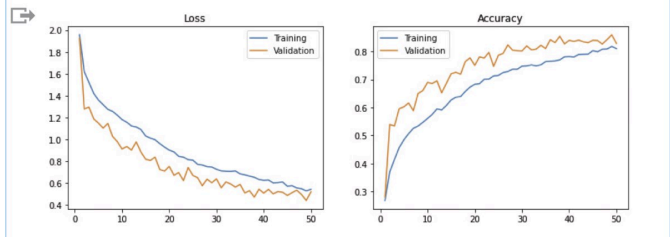

In [ ]:
# 손실함수, 정확도 그래프 그리기
#plot_loss_acc(aug_history, 50)

### **4-5. ResNet 사전 학습 모델**
- ResNet 모델을 활용해 위성 이미지 분류
- 전이 학습: 훈련을 받는 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성

- ResNet50V2 버전 사용
- (64, 64, 3)을 input_shape 속성에 지정
- 분류하려는 클래스 레이블의 개수를 classes 속성에 지정
- include_top = False 지정하여 Top 층 제거
  + 최종 분류기를 대체해서 추가 

94668760/94668760 [==============================] - 2s 0us/step


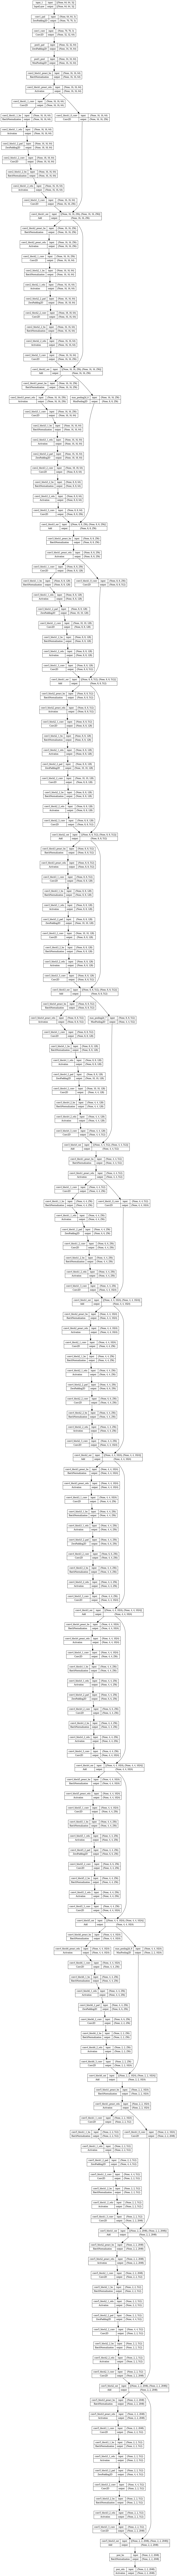

In [27]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

- NUM_CLASSES 변수는 위성 이미지의 클래스 레이블 개수인 1-을 값으로 가짐
- 최종적으로 10개의 클래스에 대한 다중 분류를 할 수 있도록 Dense 레이어의 노드 개수와 softmax 활성화 함수 지정 

In [28]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([
      
      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               